In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install Pillow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import re
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Controlling the class balance




In [ ]:
import os

folder_path = "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/1stAugmentationSet/HataVar"

# Iterate over each subfolder in the top folder
for fabric_folder in os.listdir(folder_path):
    fabric_path = os.path.join(folder_path, fabric_folder)

    # Check if the subfolder is a directory
    if os.path.isdir(fabric_path):
        image_count = 0

        # Iterate over each file in the subfolder
        for file_name in os.listdir(fabric_path):
            file_path = os.path.join(fabric_path, file_name)

            # Check if the file is an image
            if os.path.isfile(file_path) and file_name.lower().endswith((".jpg", ".jpeg", ".png", ".gif")):
                image_count += 1

        print(f"{fabric_folder}: {image_count} images")


YagLekesiVeRenkHatasi: 54 images
İplikHatasi: 54 images
KumasDokusundaYabanciCisim: 51 images
DelikVeKesikHatasi: 54 images


In [ ]:
def count_images_in_folder(folder_path):
    total_images = 0

    # Iterate over each subfolder in the folder
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Count the number of images in the subfolder
            subfolder_images = count_images_in_subfolder(subfolder_path)
            total_images += subfolder_images

    return total_images

def count_images_in_subfolder(subfolder_path):
    subfolder_images = 0

    # Iterate over each file in the subfolder
    for file in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, file)
        if os.path.isdir(file_path):
            # Recursively count images in inner subfolders
            subfolder_images += count_images_in_subfolder(file_path)
        elif os.path.isfile(file_path):
            # Check if the file is an image
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                subfolder_images += 1

    return subfolder_images

folder_path = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/1stAugmentationSet/HataVar'  # Replace with the actual path to your folder
total_images = count_images_in_folder(folder_path)

print("Total number of images in HataVarBalanced folder:", total_images)

Total number of images in HataVarBalanced folder: 213


In [ ]:
import os

def count_images(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter for image files (modify the condition as per your requirements)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Count the number of image files
    num_images = len(image_files)

    return num_images

# Example usage
folder_path = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/1stAugmentationSet/HataYok'

num_images = count_images(folder_path)
print(f"Number of images in the HataYok folder: {num_images}")


Number of images in the HataYok folder: 213


2. Train Test Validation Split

In [ ]:
import os
import shutil
import random

def create_folder_structure(output_folder):
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    val_folder = os.path.join(output_folder, 'validation')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    hata_var_train_folder = os.path.join(train_folder, 'HataVar')
    hata_yok_train_folder = os.path.join(train_folder, 'HataYok')
    hata_var_test_folder = os.path.join(test_folder, 'HataVar')
    hata_yok_test_folder = os.path.join(test_folder, 'HataYok')
    hata_var_val_folder = os.path.join(val_folder, 'HataVar')
    hata_yok_val_folder = os.path.join(val_folder, 'HataYok')

    os.makedirs(hata_var_train_folder, exist_ok=True)
    os.makedirs(hata_yok_train_folder, exist_ok=True)
    os.makedirs(hata_var_test_folder, exist_ok=True)
    os.makedirs(hata_yok_test_folder, exist_ok=True)
    os.makedirs(hata_var_val_folder, exist_ok=True)
    os.makedirs(hata_yok_val_folder, exist_ok=True)

def split_dataset(input_folder, output_folder, train_percent, test_percent, val_percent, random_seed):
    # Set the random seed
    random.seed(random_seed)

    # Create the folder structure
    create_folder_structure(output_folder)

    # Separate HataYok folder
    hata_yok_folder = os.path.join(input_folder, 'HataYok')
    hata_yok_images = [image for image in os.listdir(hata_yok_folder) if os.path.isfile(os.path.join(hata_yok_folder, image))]
    random.shuffle(hata_yok_images)

    # Calculate the number of HataYok images for each set
    num_hata_yok_images = len(hata_yok_images)
    num_train_hata_yok = int(num_hata_yok_images * train_percent)
    num_test_hata_yok = int(num_hata_yok_images * test_percent)
    num_val_hata_yok = num_hata_yok_images - num_train_hata_yok - num_test_hata_yok

    # Split HataYok images
    train_hata_yok_images = hata_yok_images[:num_train_hata_yok]
    test_hata_yok_images = hata_yok_images[num_train_hata_yok:num_train_hata_yok + num_test_hata_yok]
    val_hata_yok_images = hata_yok_images[num_train_hata_yok + num_test_hata_yok:]

    # Move HataYok images to the corresponding folders in the output directory
    for image in train_hata_yok_images:
        src = os.path.join(hata_yok_folder, image)
        dest = os.path.join(output_folder, 'train', 'HataYok', image)
        shutil.copy(src, dest)

    for image in test_hata_yok_images:
        src = os.path.join(hata_yok_folder, image)
        dest = os.path.join(output_folder, 'test', 'HataYok', image)
        shutil.copy(src, dest)

    for image in val_hata_yok_images:
        src = os.path.join(hata_yok_folder, image)
        dest = os.path.join(output_folder, 'validation', 'HataYok', image)
        shutil.copy(src, dest)

    # Separate HataVar folder and its subfolders
    hata_var_folder = os.path.join(input_folder, 'HataVar')

    for subfolder in os.listdir(hata_var_folder):
        subfolder_path = os.path.join(hata_var_folder, subfolder)
        if os.path.isdir(subfolder_path):
            # Get the images from the current subfolder
            subfolder_images = [image for image in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, image))]
            random.shuffle(subfolder_images)

            # Calculate the number of images for each set
            num_images = len(subfolder_images)
            num_train = int(num_images * train_percent)
            num_test = int(num_images * test_percent)
            num_val = num_images - num_train - num_test

            # Split images for the current subfolder
            train_images = subfolder_images[:num_train]
            test_images = subfolder_images[num_train:num_train + num_test]
            val_images = subfolder_images[num_train + num_test:]

            # Move images to the corresponding folders in the output directory
            for image in train_images:
                src = os.path.join(subfolder_path, image)
                dest = os.path.join(output_folder, 'train', 'HataVar', subfolder, image)
                shutil.copy(src, dest)

            for image in test_images:
                src = os.path.join(subfolder_path, image)
                dest = os.path.join(output_folder, 'test', 'HataVar', subfolder, image)
                shutil.copy(src, dest)

            for image in val_images:
                src = os.path.join(subfolder_path, image)
                dest = os.path.join(output_folder, 'validation', 'HataVar', subfolder, image)
                shutil.copy(src, dest)

    print("Dataset split successfully.")

# Usage example
input_folder = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/1stAugmentationSet'
output_folder = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation'
train_percent = 0.8
test_percent = 0.1
val_percent = 0.1
random_seed = 42

split_dataset(input_folder, output_folder, train_percent, test_percent, val_percent, random_seed)


Dataset split successfully.


In [ ]:
import os


def get_percentage(directory):
    total_images = 0
    class_counts = {}

    # Iterate over the classes (subfolders) in the directory
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if not os.path.isdir(class_path):
            continue

        if class_folder in ["train", "validation", "test"]:
            # Count the number of images in the folder and subfolders
            num_images = count_images(class_path)

            # Update the total count and class count
            total_images += num_images
            class_counts[class_folder] = num_images

    # Calculate the percentages
    percentages = {}
    for class_folder, count in class_counts.items():
        percentage = (count / total_images) * 100
        percentages[class_folder] = percentage

    return percentages


def count_images(directory):
    count = 0

    # Iterate over the files and subdirectories in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isfile(item_path):
            count += 1
        elif os.path.isdir(item_path):
            count += count_images(item_path)

    return count


# Set the directory to analyze
directory = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation'

# Get the percentage of images in train, test, and validation folders
percentages = get_percentage(directory)

# Print the percentages
for class_folder, percentage in percentages.items():
    print(f"Percentage of {class_folder}: {percentage}%")


Percentage of train: 79.5774647887324%
Percentage of test: 9.624413145539906%
Percentage of validation: 10.7981220657277%


3. Controlling the class balance after dataset split.

In [ ]:
base_dirs = [
    "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/test/HataVar",
    "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/train/HataVar",
    "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/validation/HataVar"
]

# Traverse the directory structure
for base_dir in base_dirs:
    # Initialize an empty dictionary to store the counts
    counts = {}

    for fabric_folder in ["DelikVeKesikHatasi", "İplikHatasi", "KumasDokusundaYabanciCisim", "YagLekesiVeRenkHatasi"]:
        fabric_path = os.path.join(base_dir, fabric_folder)
        count = sum([1 for file in os.listdir(fabric_path) if file.endswith(".jpg")])
        counts.setdefault(fabric_folder, 0)
        counts[fabric_folder] += count

    # Create a dataframe from the counts dictionary
    df = pd.DataFrame.from_dict(counts, orient="index", columns=["Total Images"])

    # Sort the dataframe by fabric names
    df = df.sort_index()

    # Extract the directory name
    directory_name = os.path.relpath(base_dir, "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation")

    # Print the directory name
    print("Directory:", directory_name)

    # Print the dataframe
    print(df)
    print()

Directory: test/HataVar
                            Total Images
DelikVeKesikHatasi                     5
İplikHatasi                           5
KumasDokusundaYabanciCisim             5
YagLekesiVeRenkHatasi                  5

Directory: train/HataVar
                            Total Images
DelikVeKesikHatasi                    43
İplikHatasi                          43
KumasDokusundaYabanciCisim            40
YagLekesiVeRenkHatasi                 43

Directory: validation/HataVar
                            Total Images
DelikVeKesikHatasi                     6
İplikHatasi                           6
KumasDokusundaYabanciCisim             6
YagLekesiVeRenkHatasi                  6



In [ ]:
import os


def count_images(directory):
    count = 0

    # Iterate over the files in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isfile(item_path):
            count += 1

    return count


# Set the directories of the HataYok folders in train, test, and validation
test_directory = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/test/HataYok'
train_directory = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/train/HataYok'
val_directory = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/validation/HataYok'

# Count the number of images in the HataYok folders
num_images_test = count_images(test_directory)
num_images_train = count_images(train_directory)
num_images_val = count_images(val_directory)

# Print the number of images
print(f"Number of images in test HataYok folder: {num_images_test}")
print(f"Number of images in train HataYok folder: {num_images_train}")
print(f"Number of images in val HataYok folder: {num_images_val}")


Number of images in test HataYok folder: 21
Number of images in train HataYok folder: 170
Number of images in val HataYok folder: 22


In [ ]:
import os

root_folder = "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation"  # Replace with the actual root folder path

# Dictionary to store the counts
counts = {}

# Iterate over the subdirectories of the root folder
for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)
    if os.path.isdir(folder_path):
        hata_var_folder = os.path.join(folder_path, "HataVar")
        hata_yok_folder = os.path.join(folder_path, "HataYok")

        # Count the images in HataVar folder
        if os.path.exists(hata_var_folder):
            hata_var_count = len(os.listdir(hata_var_folder))
            counts[folder_name] = {"HataVar": hata_var_count}

        # Count the images in HataYok folder
        if os.path.exists(hata_yok_folder):
            hata_yok_count = len(os.listdir(hata_yok_folder))
            if folder_name in counts:
                counts[folder_name]["HataYok"] = hata_yok_count
            else:
                counts[folder_name] = {"HataYok": hata_yok_count}

# Print the counts
for folder_name, folder_counts in counts.items():
    print("Folder:", folder_name)
    for hata_type, count in folder_counts.items():
        print("Number of images in", hata_type, "folder:", count)
    print()


Folder: train
Number of images in HataVar folder: 169
Number of images in HataYok folder: 170

Folder: test
Number of images in HataVar folder: 20
Number of images in HataYok folder: 21

Folder: validation
Number of images in HataVar folder: 24
Number of images in HataYok folder: 22



4. Image size controlling

In [ ]:
def get_unique_image_sizes(directory):
    image_sizes = set()
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

    for root, _, files in os.walk(directory):
        for file in files:
            _, extension = os.path.splitext(file)
            if extension.lower() in image_extensions:
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        image_sizes.add((width, height))
                except Exception as e:
                    print(f"Error opening image: {image_path}")
                    print(str(e))

    return image_sizes

directory_path = "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation"  # Replace with the actual directory path
train_directory = os.path.join(directory_path, 'train')
test_directory = os.path.join(directory_path, 'test')
validation_directory = os.path.join(directory_path, 'validation')

print("Unique image sizes in the train folder:")
train_sizes = get_unique_image_sizes(train_directory)
for size in train_sizes:
    print(size)

print("\nUnique image sizes in the test folder:")
test_sizes = get_unique_image_sizes(test_directory)
for size in test_sizes:
    print(size)

print("\nUnique image sizes in the validation folder:")
validation_sizes = get_unique_image_sizes(validation_directory)
for size in validation_sizes:
    print(size)

Unique image sizes in the train folder:
(416, 416)

Unique image sizes in the test folder:
(416, 416)

Unique image sizes in the validation folder:
(416, 416)


5. Attainng labels to the images within the train test validation folders.

In [3]:
# Define the train, test, and validation directory paths

# Set the paths to the train, test, and validation datasets
train_dir = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/train'
test_dir = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/test'
validation_dir = '/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/validation'

# Set the image size and batch size for the datasets
image_size = (416, 416)
batch_size = 32

# Load the train dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

# Load the test dataset from the directory
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

# Load the validation dataset from the directory
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

Found 339 files belonging to 2 classes.
Found 41 files belonging to 2 classes.
Found 46 files belonging to 2 classes.


6. Checking image leakage between train and test sets.

In [ ]:
import os
import hashlib

def check_image_leakage(train_dir, test_dir):
    train_images = get_image_files(train_dir)
    test_images = get_image_files(test_dir)

    common_images = train_images.intersection(test_images)

    if common_images:
        print("Image leakage detected!")
        print("Leaked images:")
        for image_path in common_images:
            print(image_path)
    else:
        print("No image leakage detected.")

def calculate_image_hash(image_path):
    with open(image_path, 'rb') as f:
        image_data = f.read()
        image_hash = hashlib.md5(image_data).hexdigest()
    return image_hash

def check_image_similarity(train_dir, test_dir):
    train_images = get_image_files(train_dir)
    test_images = get_image_files(test_dir)

    for train_image_path in train_images:
        train_image_hash = calculate_image_hash(train_image_path)

        for test_image_path in test_images:
            test_image_hash = calculate_image_hash(test_image_path)

            if train_image_hash == test_image_hash:
                print("Image leakage detected!")
                print(f"Leaked images: {train_image_path} and {test_image_path}")
                return

    print("No image leakage detected.")

def get_image_files(directory):
    image_files = set()
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                image_files.add(os.path.join(root, file))
    return image_files

# Example usage:
train_directory = "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/train"
test_directory = "/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/TrainTestValidation/test"

# Check for image leakage by comparing image file names
check_image_leakage(train_directory, test_directory)

# Check for image leakage by comparing image hashes
check_image_similarity(train_directory, test_directory)


No image leakage detected.
No image leakage detected.


7. Image and label match checking.

In [ ]:
for images, labels in train_dataset:
    print(images.shape)
    print(labels.shape)
    break

(32, 416, 416, 3)
(32, 1)


tf.Tensor([1.], shape=(1,), dtype=float32)


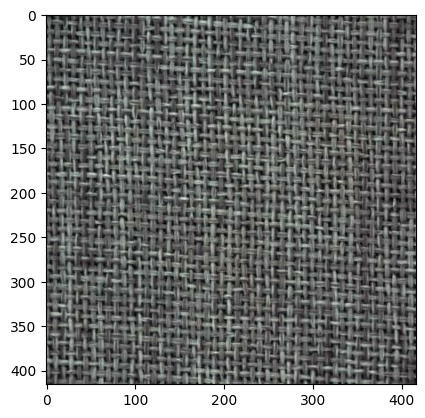

In [ ]:
plt.imshow(images[0].numpy().astype("uint32"))
print(labels[0])

tf.Tensor([1.], shape=(1,), dtype=float32)


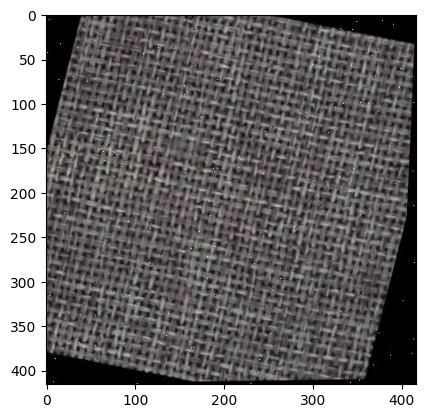

In [ ]:
plt.imshow(images[5].numpy().astype("uint32"))
print(labels[5])

tf.Tensor([0.], shape=(1,), dtype=float32)


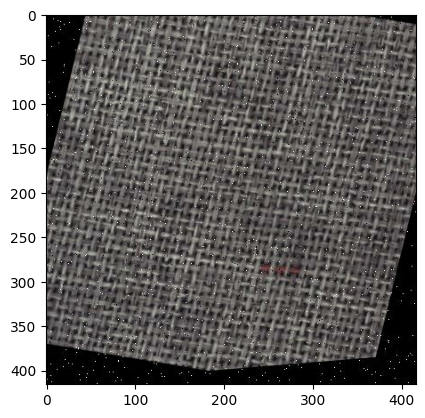

In [ ]:
plt.imshow(images[21].numpy().astype("uint32"))
print(labels[21])

In [ ]:
# Get the unique categorical labels from the train dataset
unique_labels = train_dataset.class_names

# Print the unique categorical labels
print(unique_labels)

['HataVar', 'HataYok']


In [ ]:
# Get the unique categorical labels from the train dataset
unique_labels = test_dataset.class_names

# Print the unique categorical labels
print(unique_labels)

['HataVar', 'HataYok']


In [ ]:
# Get the unique categorical labels from the train dataset
unique_labels = validation_dataset.class_names

# Print the unique categorical labels
print(unique_labels)

['HataVar', 'HataYok']


8. CNN Model Training and Testing

In [4]:
img_size = (416, 416, 3)
inputs = keras.Input(shape = img_size)
x = layers.Rescaling(1/255.0)(inputs)
x = layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPool2D(pool_size = (2,2),padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation = "relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
mdl = keras.Model(inputs, outputs)

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience=30)

mdl.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

history = mdl.fit(train_dataset, epochs=30, batch_size = 32,
                    validation_data=validation_dataset,
                    callbacks = [early_stop])

Epoch 1/30
11/11 [==============================] - 53s 1s/step - loss: 1.5995 - accuracy: 0.4690 - val_loss: 0.6944 - val_accuracy: 0.3696
Epoch 2/30
11/11 [==============================] - 4s 322ms/step - loss: 0.6823 - accuracy: 0.5900 - val_loss: 0.6946 - val_accuracy: 0.4565
Epoch 3/30
11/11 [==============================] - 4s 329ms/step - loss: 0.6409 - accuracy: 0.6785 - val_loss: 0.7085 - val_accuracy: 0.4783
Epoch 4/30
11/11 [==============================] - 4s 332ms/step - loss: 0.5136 - accuracy: 0.7522 - val_loss: 0.7863 - val_accuracy: 0.5217
Epoch 5/30
11/11 [==============================] - 4s 332ms/step - loss: 0.2845 - accuracy: 0.8820 - val_loss: 0.7359 - val_accuracy: 0.5652
Epoch 6/30
11/11 [==============================] - 4s 335ms/step - loss: 0.1010 - accuracy: 0.9735 - val_loss: 1.0234 - val_accuracy: 0.5000
Epoch 7/30
11/11 [==============================] - 4s 331ms/step - loss: 0.0617 - accuracy: 0.9882 - val_loss: 1.0084 - val_accuracy: 0.5217
Epoch 8/

9. Test and overfitting control.

In [5]:
print(mdl.evaluate(test_dataset))
print(mdl.evaluate(train_dataset))

2/2 [==============================] - 5s 680ms/step - loss: 1.7917 - accuracy: 0.4634
[1.7917134761810303, 0.46341463923454285]
11/11 [==============================] - 1s 62ms/step - loss: 6.6695e-05 - accuracy: 1.0000
[6.669548019999638e-05, 1.0]


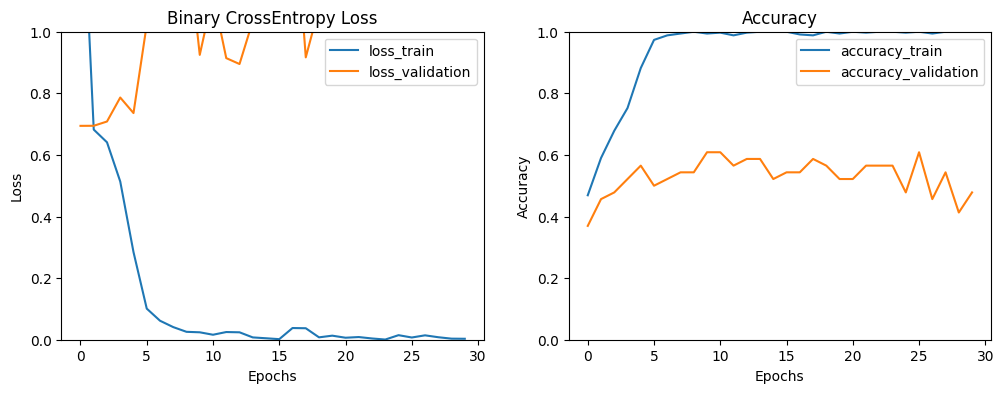

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Binary CrossEntropy Loss')
plt.plot(history.history["loss"], label="loss_train")
plt.plot(history.history["val_loss"], label="loss_validation")
plt.ylim([0.0, 1])  # Adjust the y-axis limits if needed
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history["accuracy"], label="accuracy_train")
plt.plot(history.history["val_accuracy"], label="accuracy_validation")
plt.ylim([0, 1])  # Adjust the y-axis limits if needed
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


10. Checking confusion matrix


In [7]:
import numpy as np
import pandas as pd

# Assuming you have a test_dataset containing input images and labels
test_images = []
true_labels = []
for image, label in test_dataset:
    test_images.append(image)
    true_labels.append(label)

# Concatenate the test images into a single numpy array
test_images = np.concatenate(test_images, axis=0)

# Predict labels for the test images
predicted_labels = mdl.predict(test_images)

# If your output is binary (1 neuron with sigmoid activation), you can round the predictions
predicted_labels = np.round(predicted_labels)

# If your output is multi-class (e.g., using softmax activation), you can use argmax to get the predicted class indices
# predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert the true labels to a numpy array
true_labels = np.concatenate(true_labels, axis=0)


# Set the display options to show the complete arrays
np.set_printoptions(threshold=np.inf)

# Create a DataFrame with true labels and predicted labels
df = pd.DataFrame({"True Labels": true_labels.flatten(), "Predicted Labels": predicted_labels.flatten()})

# Display the DataFrame
print(df)

df.to_excel('label_comparison2.xlsx', index=False)

2/2 [==============================] - 0s 64ms/step
    True Labels  Predicted Labels
0           1.0               0.0
1           1.0               0.0
2           0.0               1.0
3           1.0               0.0
4           1.0               0.0
5           1.0               1.0
6           0.0               0.0
7           1.0               1.0
8           1.0               0.0
9           0.0               1.0
10          1.0               0.0
11          1.0               1.0
12          0.0               1.0
13          0.0               0.0
14          0.0               0.0
15          0.0               1.0
16          0.0               0.0
17          1.0               0.0
18          1.0               1.0
19          1.0               0.0
20          1.0               1.0
21          0.0               1.0
22          0.0               0.0
23          1.0               0.0
24          0.0               1.0
25          1.0               0.0
26          0.0               

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

def calculate_metrics(model, test_dataset):
    true_labels = []
    predicted_labels = []

    for image, label in test_dataset:
        true_labels.extend(label)
        batch_predictions = model.predict(image)
        batch_labels = np.round(batch_predictions)  # or np.argmax(batch_predictions, axis=1) for multi-class
        predicted_labels.extend(batch_labels)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    specificity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    f1 = f1_score(true_labels, predicted_labels)

    return confusion_mat, accuracy, recall, precision, specificity, f1

# Assuming you have two CNN models called model1 and model2
confusion_mat2, accuracy2, recall2, precision2, specificity2, f1_2 = calculate_metrics(mdl, test_dataset)

# Print the confusion matrix and metrics for the second model
print("Model 1 for test:")
print(confusion_mat2)
print("Accuracy:", accuracy2)
print("Recall:", recall2)
print("Precision:", precision2)
print("Specificity:", specificity2)
print("F1-score:", f1_2)


1/1 [==============================] - 0s 36ms/step
Model 1 for test:
[[11  9]
 [13  8]]
Accuracy: 0.4634146341463415
Recall: 0.38095238095238093
Precision: 0.47058823529411764
Specificity: 0.55
F1-score: 0.42105263157894735


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

def calculate_metrics(model, test_dataset):
    true_labels = []
    predicted_labels = []

    for image, label in test_dataset:
        true_labels.extend(label)
        batch_predictions = model.predict(image)
        batch_labels = np.round(batch_predictions)  # or np.argmax(batch_predictions, axis=1) for multi-class
        predicted_labels.extend(batch_labels)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    specificity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    f1 = f1_score(true_labels, predicted_labels)

    return confusion_mat, accuracy, recall, precision, specificity, f1

# Assuming you have two CNN models called model1 and model2
confusion_mat2, accuracy2, recall2, precision2, specificity2, f1_2 = calculate_metrics(mdl, validation_dataset)

# Print the confusion matrix and metrics for the second model
print("Model 1 for validation:")
print(confusion_mat2)
print("Accuracy:", accuracy2)
print("Recall:", recall2)
print("Precision:", precision2)
print("Specificity:", specificity2)
print("F1-score:", f1_2)


1/1 [==============================] - 0s 44ms/step
Model 1 for validation:
[[15  9]
 [15  7]]
Accuracy: 0.4782608695652174
Recall: 0.3181818181818182
Precision: 0.4375
Specificity: 0.625
F1-score: 0.3684210526315789


1/1 [==============================] - 0s 29ms/step
Model 1:
[[11  9]
 [13  8]]
Accuracy: 0.4634146341463415
Recall: 0.38095238095238093
Precision: 0.47058823529411764
Specificity: 0.55
F1-score: 0.42105263157894735


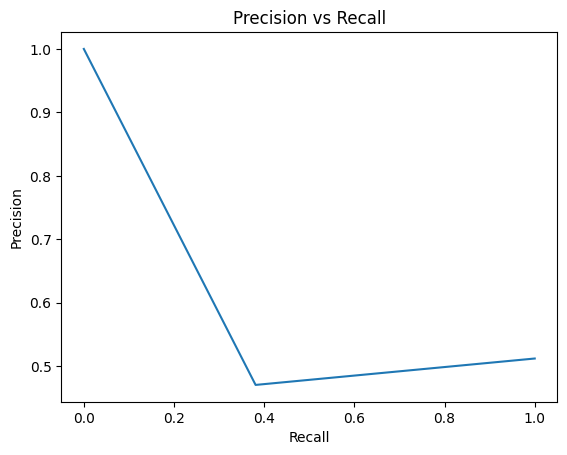

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

def calculate_metrics(model, test_dataset):
    true_labels = []
    predicted_labels = []

    for image, label in test_dataset:
        true_labels.extend(label)
        batch_predictions = model.predict(image)
        batch_labels = np.round(batch_predictions)  # or np.argmax(batch_predictions, axis=1) for multi-class
        predicted_labels.extend(batch_labels)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    specificity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    f1 = f1_score(true_labels, predicted_labels)

    return confusion_mat, accuracy, recall, precision, specificity, f1

# Assuming you have two CNN models called model1 and model2
confusion_mat2, accuracy2, recall2, precision2, specificity2, f1_2 = calculate_metrics(mdl, test_dataset)

# Print the confusion matrix and metrics for the second model
print("Model 1 for validation:")
print(confusion_mat2)
print("Accuracy:", accuracy2)
print("Recall:", recall2)
print("Precision:", precision2)
print("Specificity:", specificity2)
print("F1-score:", f1_2)

# Calculate precision and recall curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)

# Plot precision vs recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.show()


In [11]:
# Save the trained model
mdl.save('/content/drive/MyDrive/GönderilecekBinaryClassification/1stAugmentation/mdl0.h5')  # Replace '/path/to/save/model.h5' with the desired path and filename for your saved model
